换了一种方法些蒙特卡洛模拟
跑完模拟画了下distribution

随机过程St在满足以下随机微分方程的情况下被认为遵循几何布朗运动：
    - St表示资产价格，Wt是一个维纳过程，或者说是布朗运动（随机数），μ代表预期收益率，σ代表波动率。
    - 即资产价格变动有两个组成部分：代表资产价格的漂移项(Drift，即恒定的定向运动)，以及代表市场波动（Volatility）的随机输入。

模型构建
    - 选用资产：GOOGLE
    - 漂移项：平均日回报-方差/2，其中：日回报=ln（当日价格/上一日价格）
    - 随机变量：波动率×正态分布随机数

In [595]:
import numpy as np
import pandas as pd
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from pandas_datareader import data as wb

In [596]:
###从yahoo finance 获取价格数据
df = yf.download("GOOG",
                 start= "2020-01-01",
                 progress = False)
df['simple_rtn'] = df['Adj Close'].pct_change().dropna()
df['log_rtn'] = np.log(1 + df['simple_rtn'])
df.head()


,Open,High,Low,Close,Adj Close,Volume,simple_rtn,log_rtn
Date,,,,,,,,
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000,NaN,NaN
2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000,-0.004907,-0.004919
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000,0.024657,0.024358
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000,-0.000624,-0.000624
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000,0.007880,0.007850


<Axes: title={'center': 'Google Price chart'}, xlabel='Date'>

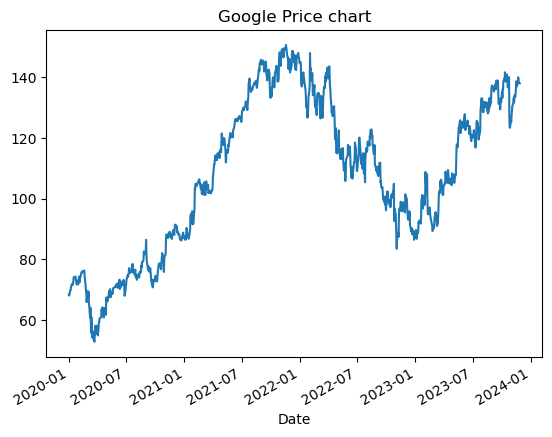

In [597]:
###计算回报

df['simple_rtn'] = df['Adj Close'].pct_change().dropna()
df['log_rtn'] = np.log(1 + df['simple_rtn'])
df.head()


##股价的单独图片
df['Adj Close'].plot(title = 'Google Price chart')

<BarContainer object of 983 artists>

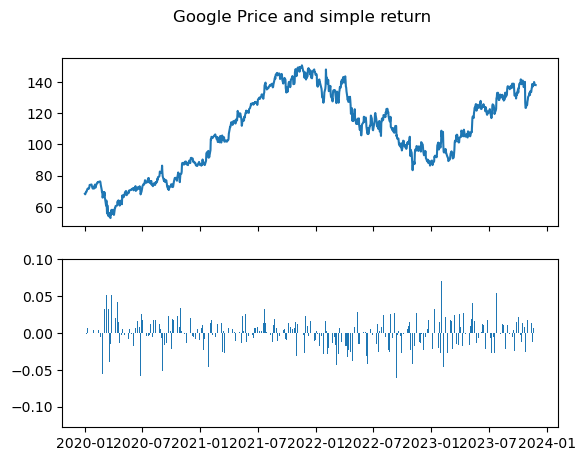

In [598]:
##在share x axis的图中画出股价线性图和log回报bar
fig, axs = plt.subplots(2,sharex=True)
fig.suptitle('Google Price and simple return')
axs[0].plot(df['Adj Close'])
axs[1].bar(df.index,df['log_rtn'])

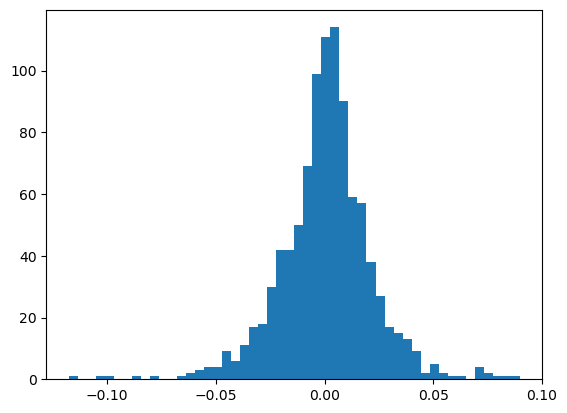

In [599]:
##查看分布histogram 以及相同均值/波动率的正态分布线
plt.hist(df['log_rtn'],bins = 50)
plt.show()

<Axes: xlabel='log_rtn', ylabel='Count'>

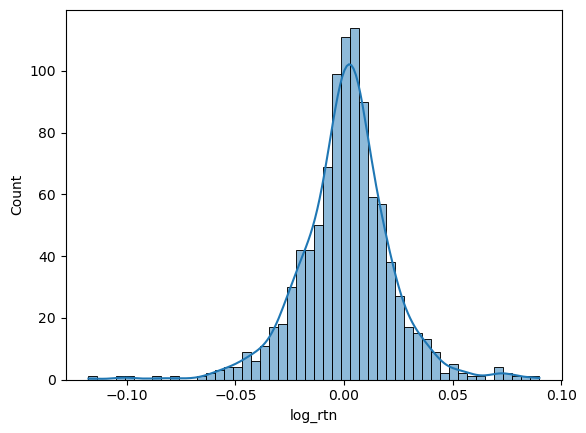

In [600]:
sns.histplot(df['log_rtn'], kde=True, bins=50)

drift / mu / sigma calc

In [601]:
mu = df['log_rtn'].mean()
sigma = df['log_rtn'].std()
S_0 = df['Adj Close'][-1]
drift = mu - 0.5*sigma**2
S_0

138.0500030517578

generate random variables for every day forecasted and for every simulation trial we will run.

In [602]:
days = 50
trials = 10000
z = np.random.normal(size=(days,trials))

Calculating the stock price for every trial

In [603]:
daily_rtn =np.exp(drift + sigma *z)
#daily_rtn

convert daily return simulation data to price data frame

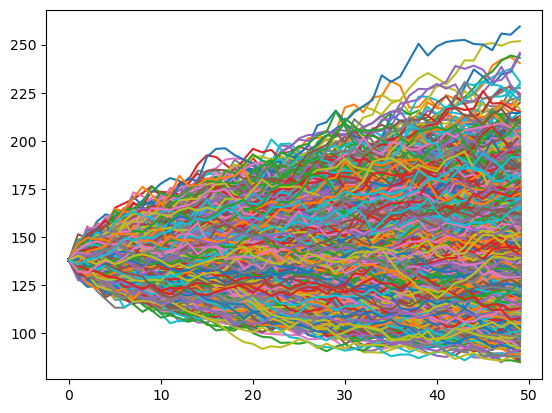

In [604]:
price_series = np.zeros_like(z)

price_series[0] = df['Adj Close'][-1]
price_series

for t in range (1,days):
    price_series[t] = price_series[t-1]*daily_rtn[t]


plt.plot(price_series)
plt.show()

Automating the Monte Carlo Simulations as functions

Step 1: import data from Yahoo finance

In [605]:
def importdata(tickers,start="2020-01-01",end="2022-01-31"):
    data = yf.download(tickers, start = start, end = end, progress= False)['Adj Close']
    return(data)

###Example: 
data = importdata("MSFT")
df=np.log(1 + data.pct_change().dropna())
df

Date
2020-01-03   -0.012530
2020-01-06    0.002581
2020-01-07   -0.009160
2020-01-08    0.015803
2020-01-09    0.012415
                ...   
2022-01-24    0.001148
2022-01-25   -0.026948
2022-01-26    0.028095
2022-01-27    0.010494
2022-01-28    0.027695
Name: Adj Close, Length: 523, dtype: float64

step 2: Compute log return

In [606]:
def logreturns(price):
    df = np.log(1 + price.pct_change().dropna())
    return(df)

###Example: 
logreturn = logreturns(data)
logreturn

Date
2020-01-03   -0.012530
2020-01-06    0.002581
2020-01-07   -0.009160
2020-01-08    0.015803
2020-01-09    0.012415
                ...   
2022-01-24    0.001148
2022-01-25   -0.026948
2022-01-26    0.028095
2022-01-27    0.010494
2022-01-28    0.027695
Name: Adj Close, Length: 523, dtype: float64

step 3: Calculate log return

In [607]:
def drift_calc(data):
    logreturn = logreturns(data)
    mu = logreturn.mean()
    sigma = logreturn.std()
    drift = mu - 0.5*sigma**2
    return(drift)
#Example use
drift_calc(data)

0.0010477780375509425

Step 4: Compute Daily Returns

In [594]:
def daily_rtns(data,days,iterations):
    daily_rtn =np.exp(drift_calc(data) + logreturns(data).std() * norm.ppf(np.random.rand(days, iterations)))
    return(daily_rtn)

#Example use
daily_rtns(data, 50, 1000)

array([[0.97760747, 1.03344225, 1.00927725, ..., 1.02746451, 0.98607518,
        1.00452031],
       [0.99458907, 0.96816911, 0.98597373, ..., 0.99122072, 1.01258402,
        0.99655946],
       [0.94205597, 0.9966609 , 1.01668476, ..., 1.03117066, 0.9919016 ,
        1.00653402],
       ...,
       [1.01631507, 1.02238232, 1.01464685, ..., 0.99260099, 1.02264867,
        1.01178788],
       [0.99092108, 1.00521552, 0.99143123, ..., 0.99321106, 1.01501374,
        0.97699038],
       [1.00416995, 0.95949618, 1.03290463, ..., 1.00722294, 0.98575432,
        1.01436037]])